# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

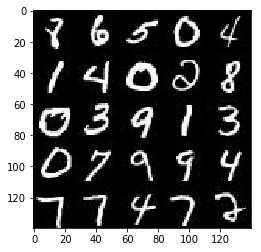

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

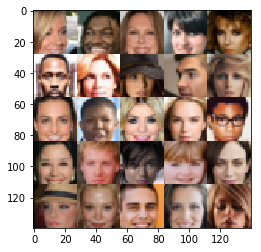

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/heyan/anaconda/envs/tensorflow1.1/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
# Define Leaky Relu First
def leaky_relu(x, alpha = 0.05):
    return tf.maximum(alpha*x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input Layer
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = leaky_relu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = leaky_relu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = leaky_relu(bn3)
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat ,1)
        outputs = tf.sigmoid(logits)

    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Set alpha for leaky_relu function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        # 8x8x256 
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        # 16x16x128 
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 
        
        outputs = tf.tanh(logits)
    
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 80
    print_every = 10
    
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 0.2178... Generator Loss: 1.8956
Epoch 1/2... Discriminator Loss: 2.8699... Generator Loss: 0.0739
Epoch 1/2... Discriminator Loss: 1.7788... Generator Loss: 7.9173
Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 7.0131
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 7.3473
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 1.7651


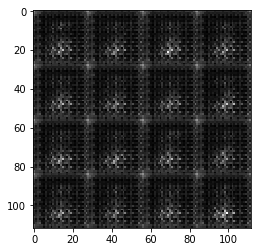

Epoch 1/2... Discriminator Loss: 0.1754... Generator Loss: 3.0643
Epoch 1/2... Discriminator Loss: 0.2340... Generator Loss: 2.0673
Epoch 1/2... Discriminator Loss: 0.1235... Generator Loss: 3.1725
Epoch 1/2... Discriminator Loss: 0.0689... Generator Loss: 3.5500
Epoch 1/2... Discriminator Loss: 0.1685... Generator Loss: 2.8864
Epoch 1/2... Discriminator Loss: 0.1429... Generator Loss: 2.9513
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 1.6222
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 2.9645


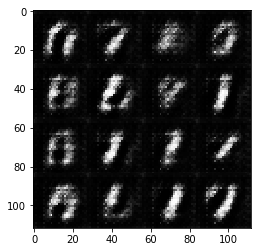

Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 2.0947
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 1.6054
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 2.7676
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.4213
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 2.5035
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 2.9553


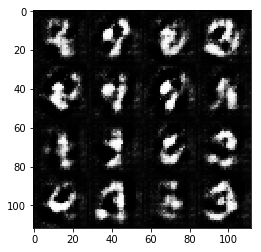

Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.9864
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.9744
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 1.6142
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 1.9378
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 1.6514
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.2785


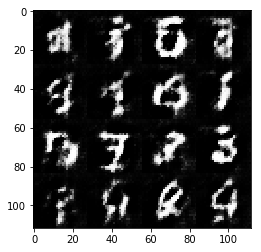

Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 0.6700... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.6363
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 3.1005
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.1449


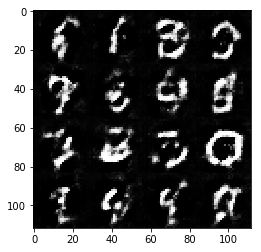

Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 1.4103
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 2.1437
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 2.6363
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 0.9192... Generator Loss: 0.7399


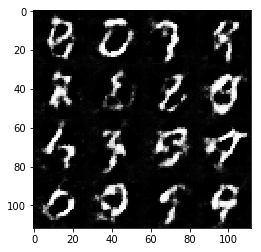

Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 1.8410
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.3483
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 1.3707


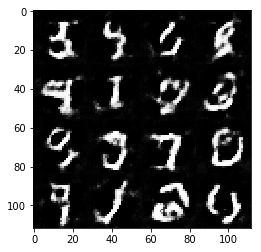

Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.2045
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 0.6722... Generator Loss: 1.5195
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 0.9941
Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 0.7750


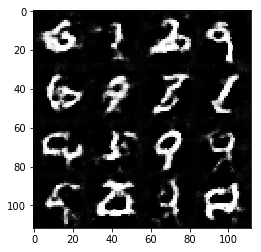

Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 2.1202
Epoch 1/2... Discriminator Loss: 0.7530... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 0.8770... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 0.6085... Generator Loss: 1.9222


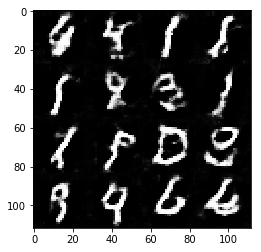

Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.3569
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 0.5737... Generator Loss: 1.2001


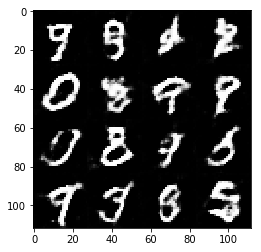

Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.4585
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.5001
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.4024
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 0.6769


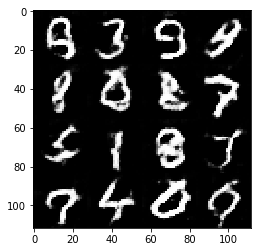

Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 1.1526
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 0.5096... Generator Loss: 1.4663
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 1.8763
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.3831
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.8525


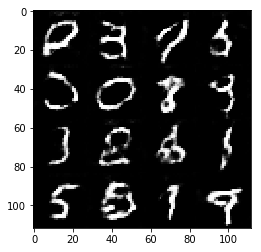

Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 1.6931
Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 0.6973... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 2.0283... Generator Loss: 0.1864
Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 0.6272... Generator Loss: 1.5323
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.1295


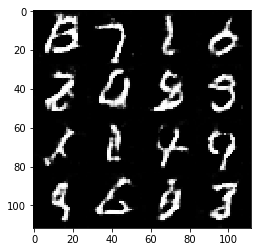

Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.8323
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.3789
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 0.9995


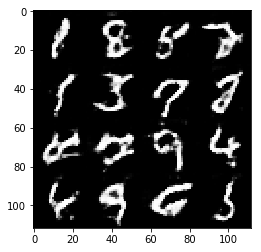

Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.4682... Generator Loss: 2.2964
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 1.6995
Epoch 2/2... Discriminator Loss: 0.4804... Generator Loss: 1.5612
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.5947


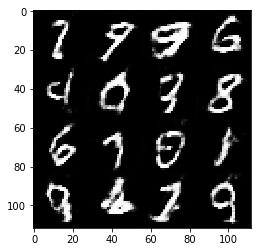

Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 1.9746
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.4678
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 1.9665
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 1.4101
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.2213
Epoch 2/2... Discriminator Loss: 0.6093... Generator Loss: 1.0842


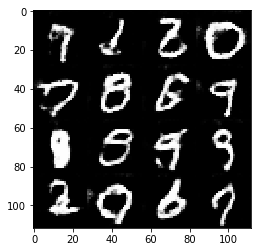

Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 1.1250
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 1.6725
Epoch 2/2... Discriminator Loss: 0.4760... Generator Loss: 1.4936
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 1.5643


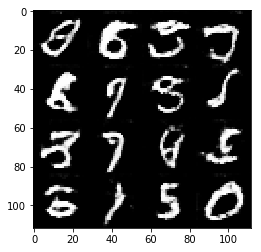

Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 2.1661
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 1.2718
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.0369


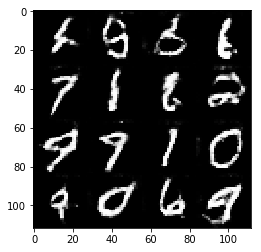

Epoch 2/2... Discriminator Loss: 0.4889... Generator Loss: 1.4871
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.2146
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 2.4323
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.3554... Generator Loss: 1.7853


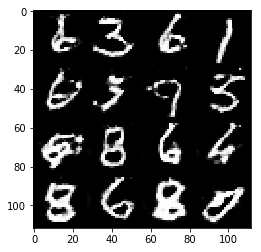

Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 1.6740
Epoch 2/2... Discriminator Loss: 0.3606... Generator Loss: 1.8156
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 1.5129
Epoch 2/2... Discriminator Loss: 6.4981... Generator Loss: 10.2290
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.5855


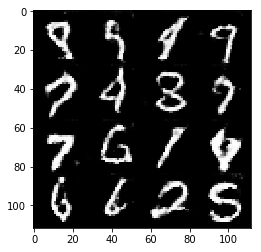

Epoch 2/2... Discriminator Loss: 0.6111... Generator Loss: 1.1076
Epoch 2/2... Discriminator Loss: 0.4303... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 1.4636
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 3.0312
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 1.9513
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 1.7297


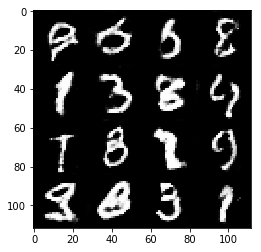

Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 1.1254
Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 0.5223... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.7283... Generator Loss: 0.3192


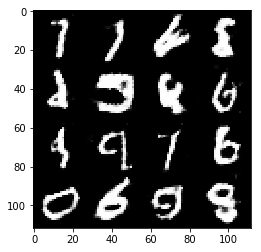

Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.1706
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.1726


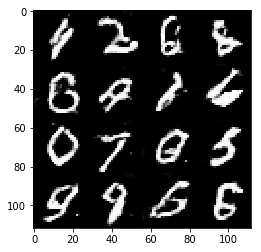

Epoch 2/2... Discriminator Loss: 0.3921... Generator Loss: 1.7594
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 3.5008
Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 1.6935
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.0962


In [38]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3018... Generator Loss: 2.4459
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 6.7954
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 1.8504
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 7.8959
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.6024
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 1.6547


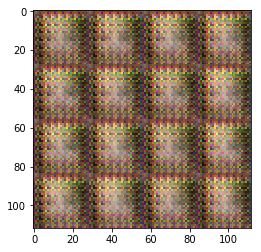

Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 1.5855
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 2.2447
Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 2.2024
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 3.0564
Epoch 1/1... Discriminator Loss: 0.1457... Generator Loss: 3.9096
Epoch 1/1... Discriminator Loss: 0.2618... Generator Loss: 2.0320
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 2.8102


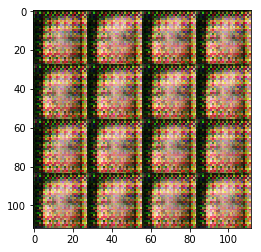

Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.1684... Generator Loss: 2.7054
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 4.3616
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 3.4678
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 2.1098


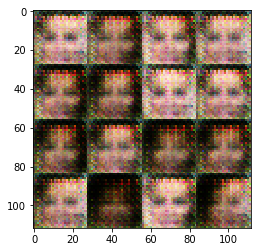

Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 2.5638
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.1604
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.6334
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.7094


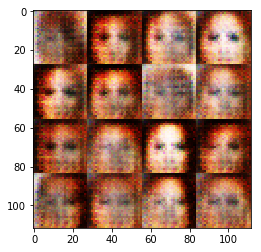

Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.9956... Generator Loss: 0.2864
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.7420


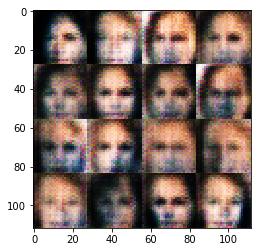

Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.0169


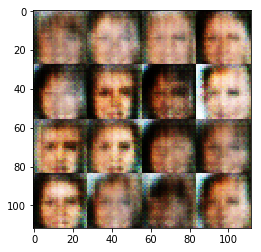

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.9586
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.7388


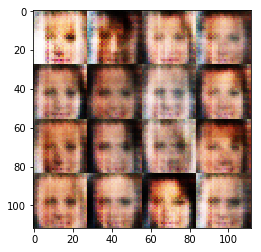

Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 2.1523
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 2.7833
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.7974... Generator Loss: 0.2538


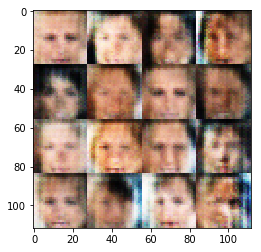

Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.9016
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 2.0581... Generator Loss: 3.6591
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.8739


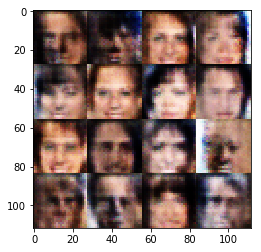

Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.8436
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9613


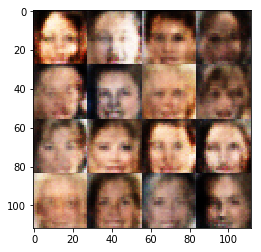

Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7744


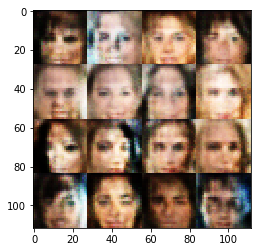

Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.2692


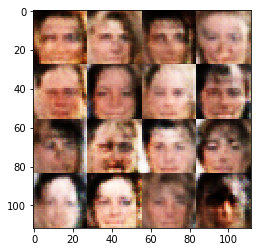

Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.7942
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.6060


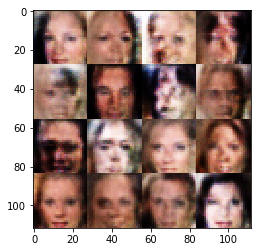

Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.5632
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.7791


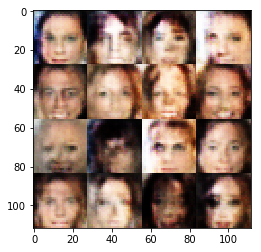

Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.3333
Epoch 1/1... Discriminator Loss: 2.0479... Generator Loss: 0.1794


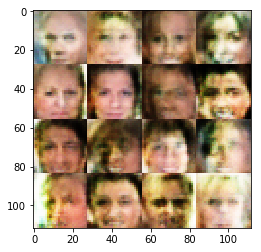

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 0.8630


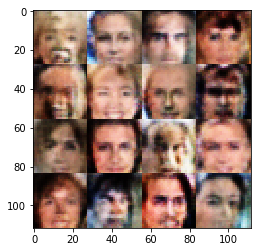

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.5074


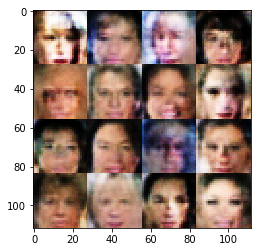

Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 2.4665
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.3274
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.9727


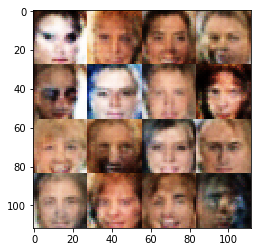

Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.7722
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.3625


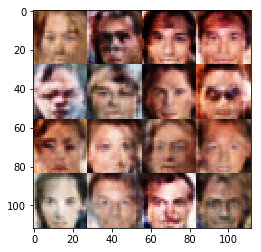

Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.6273
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 2.0917
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.9808
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.5539


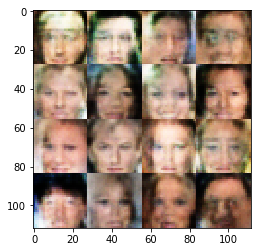

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.6034


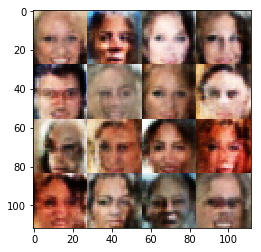

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 2.3808
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.4368


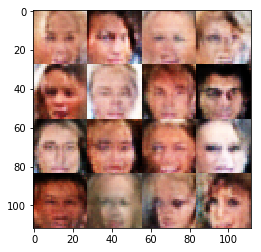

Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.1023


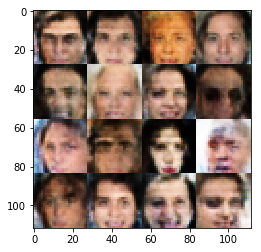

Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.2826
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.5977


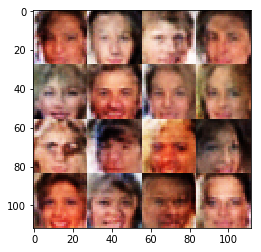

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9284


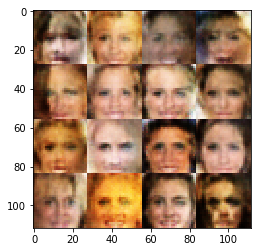

Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.7793... Generator Loss: 0.2404


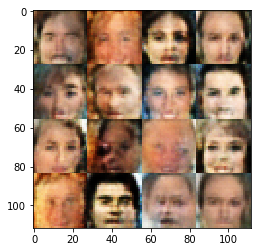

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.3581


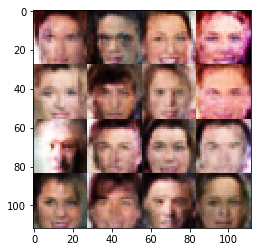

Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.3414
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9236


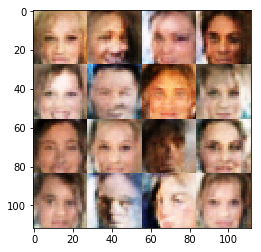

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.6823... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 0.2231
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.3032
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 0.8196


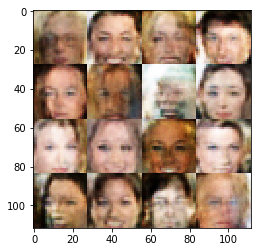

Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.5668


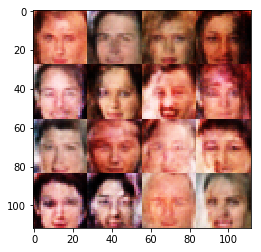

Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.7611
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 2.8669


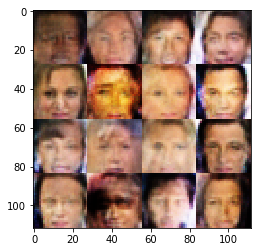

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 2.0076... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.6275


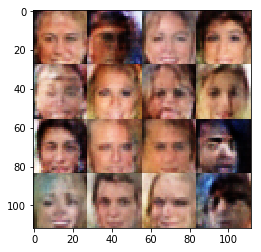

Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.7903


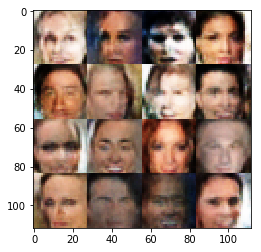

Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.4139


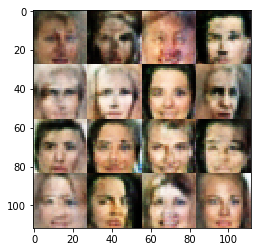

Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.3866


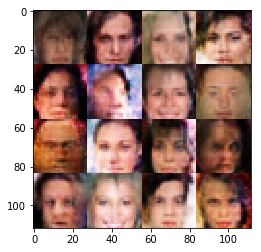

Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.7402


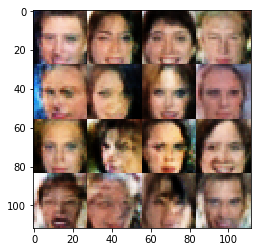

Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.3194


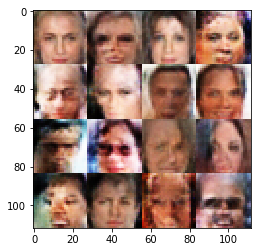

Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.2889


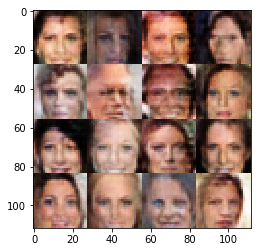

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.5176
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 0.8928


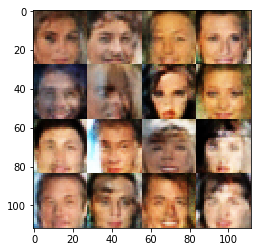

Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.7021


In [39]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.